In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/data/pjt2

/content/drive/MyDrive/data/pjt2


In [ ]:
import pandas as pd
import numpy as np

## 데이터 불러오기

In [ ]:
#train = pd.read_csv('data/train_data.csv')
train = pd.read_csv('data/데이터_추가2_전처리(불용어추가).csv')
test = pd.read_csv('data/test_final.csv')

In [ ]:
#from konlpy.tag import Okt
#tokenizer = Okt()

#x_train = [tokenizer.morphs(x) for x in train.new_title]
#x_test = [tokenizer.morphs(x) for x in test.new_title]

In [ ]:
train.columns

Index(['index', 'title', 'topic_idx'], dtype='object')

In [ ]:
train.head(2) 
# data : 한자제거 
# data2 : 특수문자 제거
# data_okt : data2 의 okt.morphs
# new_title_600 : data2의 okt+ 불용어 600제거
# new_title_600_stem : data2의 okt + 불용어 600 + stem으로 동사 변환
# new_title_one_word : new_title_600에 한글자제거

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4


In [ ]:
test.head(2)

,index,title,data,new_title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영,유튜브 내달 2일까지 크리에이터 지원 공간 운영,유튜브 내달 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사,어버이날 맑다가 흐려져…남부지방 옅은 황사,어버이날 맑다 흐려지다 남부 지방 옅다 황사


In [ ]:
train.isna().sum(), test.isna().sum()

(index        0
 title        0
 topic_idx    0
 dtype: int64, index        0
 title        0
 data         0
 new_title    0
 dtype: int64)

## XY 나누기

In [ ]:
x_train = train.title
y_train = train.topic_idx
x_test = test.title

## 데이터 확인 및 길이확인

In [ ]:
count = 0
data = []
for i in range(len(x_train)):
  if count <len(x_train[i].split()):
    count = len(x_train[i].split())
    data = x_train[i]
count, data

(13, '주말 N 여행 호남권 야간스키 씽씽 눈 덮인 덕유산에 가장 긴 슬로프 무주')

## 데이터 토크나이져

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

num_word = 0
count = 0

for i in tokenizer.word_counts.values(): # 두번이상 나타난 단어
  if i >=2:
    count +=1
    
num_word = count +2
num_word

t = Tokenizer(num_words= num_word)
t.fit_on_texts(x_train)
s = t.texts_to_sequences(x_train)

s_test = t.texts_to_sequences(x_test)

In [ ]:
x_train[0]

'인천→핀란드 항공기 결항…휴가철 여행객 분통'

In [ ]:
s_test[0]

[1224, 89, 17096, 12896, 33, 3649, 240]

## 데이터 패딩

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = max(max(len(l) for l in s), max(len(l) for l in s_test))


pad_X_train = pad_sequences(s, maxlen=max_len, padding = 'pre')
pad_X_test = pad_sequences(s_test, maxlen=max_len, padding = 'pre')

## 모델링

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, SimpleRNN

model = Sequential()

model.add(Embedding(input_dim = num_word, output_dim = 32, input_length = max_len)) #max_len 22 
model.add(SimpleRNN(32, return_sequences = True, dropout=0.15, recurrent_dropout=0.15))
model.add(SimpleRNN(32))
model.add(Dense(7, activation = 'softmax'))

model.compile(optimizer='adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 13, 32)            882048    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 13, 32)            2080      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 7)                 231       
Total params: 886,439
Trainable params: 886,439
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split

X_tn, X_tt, y_tn, y_tt = train_test_split(pad_X_train, y_train, test_size=0.33, random_state=2021)

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', 
                   mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('/content/drive/MyDrive/data/pjt2/model/rnn/rnn_model_real.h5', 
                     monitor='val_acc', mode='max', 
                     verbose=2, save_best_only=True)

history = model.fit(X_tn, y_tn, 
                    batch_size = 512, 
                    epochs = 20, 
                    callbacks=[es, mc],
                    validation_data = (X_tt, y_tt)) # 과적합 발생

Epoch 1/20
60/60 [==============================] - 5s 32ms/step - loss: 1.8440 - acc: 0.2600 - val_loss: 1.5319 - val_acc: 0.4537

Epoch 00001: val_acc improved from -inf to 0.45367, saving model to /content/drive/MyDrive/data/pjt2/model/rnn/rnn_model_real.h5
Epoch 2/20
60/60 [==============================] - 2s 26ms/step - loss: 1.1362 - acc: 0.6350 - val_loss: 0.9142 - val_acc: 0.7061

Epoch 00002: val_acc improved from 0.45367 to 0.70609, saving model to /content/drive/MyDrive/data/pjt2/model/rnn/rnn_model_real.h5
Epoch 3/20
60/60 [==============================] - 2s 26ms/step - loss: 0.6168 - acc: 0.8164 - val_loss: 0.7885 - val_acc: 0.7485

Epoch 00003: val_acc improved from 0.70609 to 0.74851, saving model to /content/drive/MyDrive/data/pjt2/model/rnn/rnn_model_real.h5
Epoch 4/20
60/60 [==============================] - 2s 26ms/step - loss: 0.3883 - acc: 0.8903 - val_loss: 0.7917 - val_acc: 0.7579

Epoch 00004: val_acc improved from 0.74851 to 0.75793, saving model to /content

## 에폭저장된거 불러옴

In [ ]:
model2 = tf.keras.models.load_model('/content/drive/MyDrive/data/pjt2/model/rnn/rnn_model_real.h5')
model2.evaluate(pad_X_train, y_train, verbose=2)

1669/1669 - 6s - loss: 0.2919 - acc: 0.9180


[0.2919265627861023, 0.9179633855819702]

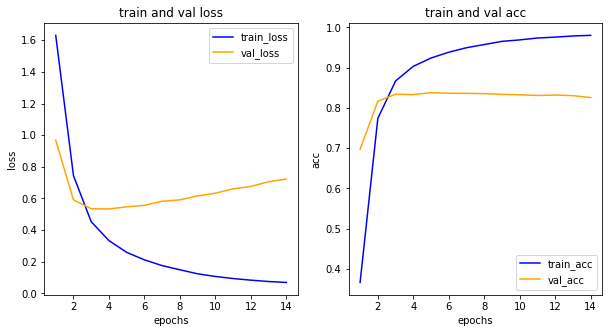

In [ ]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

## 예측

In [ ]:
pre =model.predict(pad_X_test)

In [ ]:
pre_index = [np.argmax(i) for i in pre]

In [ ]:
len(pre_index)

## sub에 넣기

In [ ]:
sub_df = pd.read_csv('sample_submission.csv')

In [ ]:
sub_df['topic_idx'] = pre_index
sub_df.to_csv('predict_rnn_final_best.csv', index=False)

In [ ]:
y_train.unique()

In [ ]:
sub_df.topic_idx.unique()